In [1]:
  
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sn
import scipy.stats as sp
import itertools
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import sklearn as skl
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, balanced_accuracy_score, accuracy_score, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor

In [2]:
df = pd.read_csv("cumulative.csv")
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
5,6,10872983,K00756.01,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
6,7,10872983,K00756.02,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


In [3]:
df.describe()

,rowid,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
count,2269.000000,2.269000e+03,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2.269000e+03,2.269000e+03,...,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000
mean,2311.372411,8.111183e+06,0.962256,0.009696,0.011459,0.002644,0.000441,26.628847,2.140485e-04,-2.140485e-04,...,-124.157338,4.409910,0.089992,-0.106000,1.068152,0.175446,-0.150149,290.954149,44.380666,14.342540
std,1716.602291,2.583776e+06,0.145710,0.098011,0.106454,0.051366,0.020993,51.383181,1.263675e-03,1.263675e-03,...,52.095882,0.235551,0.079001,0.064612,0.645425,0.143798,0.226256,4.756312,3.570394,1.221567
min,1.000000,7.574500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.341842,2.700000e-08,-5.099000e-02,...,-712.000000,2.410000,0.000000,-0.748000,0.118000,0.000000,-4.943000,280.206600,36.577381,8.224000
25%,1063.000000,6.184894e+06,0.993000,0.000000,0.000000,0.000000,0.000000,5.035057,1.129000e-05,-1.234000e-04,...,-152.000000,4.285000,0.036000,-0.126000,0.808000,0.066000,-0.164000,287.297700,41.515049,13.660000
50%,1987.000000,8.355239e+06,1.000000,0.000000,0.000000,0.000000,0.000000,11.189571,3.668000e-05,-3.668000e-05,...,-111.000000,4.453000,0.065000,-0.105000,0.969000,0.160000,-0.091000,291.145200,44.337551,14.600000
75%,3204.000000,1.018702e+07,1.000000,0.000000,0.000000,0.000000,0.000000,25.433786,1.234000e-04,-1.129000e-05,...,-83.000000,4.557000,0.130000,-0.052000,1.202000,0.243000,-0.056000,294.831020,47.208031,15.261000
max,9541.000000,1.283487e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1071.232624,5.099000e-02,-2.700000e-08,...,0.000000,5.274000,0.765000,0.000000,19.530000,2.551000,0.000000,301.720760,52.149132,17.475000


In [4]:
keplerProcessed_df = df.set_index('kepoi_name')
keplerProcessed_df.rename_axis(None, inplace=True)

keplerProcessed_df 

,rowid,kepid,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
K00752.01,1,10797460,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
K00752.02,2,10797460,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
K00755.01,5,10854555,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
K00756.01,6,10872983,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
K00756.02,7,10872983,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K03014.01,9310,7347246,Kepler-1411 b,CONFIRMED,CANDIDATE,0.941,0,0,0,0,...,-236.0,4.454,0.054,-0.216,1.053,0.357,-0.119,286.36157,42.963921,15.831
K03106.01,9354,8895758,Kepler-1427 b,CONFIRMED,CANDIDATE,0.877,0,0,0,0,...,-203.0,4.473,0.054,-0.216,1.000,0.322,-0.107,295.34967,45.114552,15.415
K00285.03,9356,6196457,Kepler-92 d,CONFIRMED,FALSE POSITIVE,0.476,1,0,0,0,...,-80.0,4.050,0.033,-0.027,1.670,0.118,-0.082,289.08606,41.562958,11.565
K03417.01,9480,7503885,Kepler-1494 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-205.0,4.437,0.072,-0.203,1.008,0.319,-0.137,282.65741,43.162521,15.214


In [5]:
# Find and drop err columns
columns_to_drop = [col for col in keplerProcessed_df.columns if '_err' in col]

keplerProcessed_df = keplerProcessed_df.drop(columns=columns_to_drop)
keplerProcessed_df

,rowid,kepid,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
K00752.01,1,10797460,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,93.59,35.8,1.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
K00752.02,2,10797460,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,9.11,25.8,2.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
K00755.01,5,10854555,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,926.16,40.9,1.0,q1_q17_dr25_tce,6031.0,4.438,1.046,288.75488,48.226200,15.509
K00756.01,6,10872983,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,114.81,66.5,1.0,q1_q17_dr25_tce,6046.0,4.486,0.972,296.28613,48.224670,15.714
K00756.02,7,10872983,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,427.65,40.2,2.0,q1_q17_dr25_tce,6046.0,4.486,0.972,296.28613,48.224670,15.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K03014.01,9310,7347246,Kepler-1411 b,CONFIRMED,CANDIDATE,0.941,0,0,0,0,...,8.93,17.8,1.0,q1_q17_dr25_tce,6161.0,4.454,1.053,286.36157,42.963921,15.831
K03106.01,9354,8895758,Kepler-1427 b,CONFIRMED,CANDIDATE,0.877,0,0,0,0,...,2730.51,12.8,1.0,q1_q17_dr25_tce,5866.0,4.473,1.000,295.34967,45.114552,15.415
K00285.03,9356,6196457,Kepler-92 d,CONFIRMED,FALSE POSITIVE,0.476,1,0,0,0,...,38.86,35.0,3.0,q1_q17_dr25_tce,5862.0,4.050,1.670,289.08606,41.562958,11.565
K03417.01,9480,7503885,Kepler-1494 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,7.02,20.8,1.0,q1_q17_dr25_tce,5915.0,4.437,1.008,282.65741,43.162521,15.214


In [6]:
# Rename columns to improve legibility
keplerProcessed_df.rename(columns={'kepid' : 'Kep ID',
                               'kepoi_name' : 'KOI Name',
                                'kepler_name' : 'Kepler Name',
                                'koi_disposition' : 'Exoplanet Archive Disposition',
                                'koi_pdisposition' : 'Disposition Using Kepler Data',
                                'koi_score' : 'Disposition Score',
                                'koi_fpflag_nt' : 'Not Transit-Like FPF',
                                'koi_fpflag_ss' : 'Stellar Eclipse FPF',
                                'koi_fpflag_co' : 'Centroid Offset FPF',
                                'koi_fpflag_ec' : 'Ephemeris Match Indicates Contamination FPF',
                                'koi_period' : 'Orbital Period [days]',
                                'koi_time0bk' : 'Transit Epoch [BKJD]',
                                'koi_impact' : 'Impact Parameter',
                                'koi_duration' : 'Transit Duration [hrs]',
                                'koi_depth' : 'Transit Depth [ppm]',
                                'koi_prad' : 'Planetary Radius [Earth radii]',
                                'koi_teq' : 'Equilibrium Temperature [K]',
                                'koi_insol' : 'Insolation Flux [Earth flux]',
                                'koi_model_snr' : 'Transit Signal-to-Noise',
                                'koi_tce_plnt_num' : 'TCE Planet Number',
                                'koi_tce_delivname' : 'TCE Delivery',
                                'ra' : 'RA [decimal degrees]',
                                'dec' : 'Dec [decimal degrees]',
                                'koi_kepmag' : 'Kepler-band [mag]'}, inplace = True)
keplerProcessed_df

,rowid,Kep ID,Kepler Name,Exoplanet Archive Disposition,Disposition Using Kepler Data,Disposition Score,Not Transit-Like FPF,Stellar Eclipse FPF,Centroid Offset FPF,Ephemeris Match Indicates Contamination FPF,...,Insolation Flux [Earth flux],Transit Signal-to-Noise,TCE Planet Number,TCE Delivery,koi_steff,koi_slogg,koi_srad,RA [decimal degrees],Dec [decimal degrees],Kepler-band [mag]
K00752.01,1,10797460,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,93.59,35.8,1.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
K00752.02,2,10797460,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,9.11,25.8,2.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
K00755.01,5,10854555,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,926.16,40.9,1.0,q1_q17_dr25_tce,6031.0,4.438,1.046,288.75488,48.226200,15.509
K00756.01,6,10872983,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,114.81,66.5,1.0,q1_q17_dr25_tce,6046.0,4.486,0.972,296.28613,48.224670,15.714
K00756.02,7,10872983,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,427.65,40.2,2.0,q1_q17_dr25_tce,6046.0,4.486,0.972,296.28613,48.224670,15.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K03014.01,9310,7347246,Kepler-1411 b,CONFIRMED,CANDIDATE,0.941,0,0,0,0,...,8.93,17.8,1.0,q1_q17_dr25_tce,6161.0,4.454,1.053,286.36157,42.963921,15.831
K03106.01,9354,8895758,Kepler-1427 b,CONFIRMED,CANDIDATE,0.877,0,0,0,0,...,2730.51,12.8,1.0,q1_q17_dr25_tce,5866.0,4.473,1.000,295.34967,45.114552,15.415
K00285.03,9356,6196457,Kepler-92 d,CONFIRMED,FALSE POSITIVE,0.476,1,0,0,0,...,38.86,35.0,3.0,q1_q17_dr25_tce,5862.0,4.050,1.670,289.08606,41.562958,11.565
K03417.01,9480,7503885,Kepler-1494 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,7.02,20.8,1.0,q1_q17_dr25_tce,5915.0,4.437,1.008,282.65741,43.162521,15.214


In [7]:
# Drop columns that do not add value to the model. These include unneeded labels

# koi_disposition and koi_score both have a high correlation to the target(y). Drop them
keplerProcessed_df.drop(["rowid","Kep ID","Kepler Name","Disposition Using Kepler Data", "Disposition Score"], axis =1, inplace=True)

In [8]:
# Convert koi_tce_delivname to numeric dummies
# This feature only has (3) values. We convert to dummies to include in the models
keplerProcessed_df = pd.get_dummies(keplerProcessed_df, columns=["TCE Delivery"])

In [9]:
#NOTE: Using the koi_pdisposition for simplification since it has (2) values.
# Lets look at what it takes to use koi_disposition instead (has 4 values)

In [10]:
# Convert koi_pdisposition to numeric, this will be the "target"
le = LabelEncoder()

keplerProcessed_df['Exoplanet Archive Disposition'] = le.fit_transform(keplerProcessed_df['Exoplanet Archive Disposition'])
keplerProcessed_df


,Exoplanet Archive Disposition,Not Transit-Like FPF,Stellar Eclipse FPF,Centroid Offset FPF,Ephemeris Match Indicates Contamination FPF,Orbital Period [days],Transit Epoch [BKJD],Impact Parameter,Transit Duration [hrs],Transit Depth [ppm],...,Insolation Flux [Earth flux],Transit Signal-to-Noise,TCE Planet Number,koi_steff,koi_slogg,koi_srad,RA [decimal degrees],Dec [decimal degrees],Kepler-band [mag],TCE Delivery_q1_q17_dr25_tce
K00752.01,0,0,0,0,0,9.488036,170.53875,0.146,2.9575,615.8,...,93.59,35.8,1.0,5455.0,4.467,0.927,291.93423,48.141651,15.347,1
K00752.02,0,0,0,0,0,54.418383,162.51384,0.586,4.5070,874.8,...,9.11,25.8,2.0,5455.0,4.467,0.927,291.93423,48.141651,15.347,1
K00755.01,0,0,0,0,0,2.525592,171.59555,0.701,1.6545,603.3,...,926.16,40.9,1.0,6031.0,4.438,1.046,288.75488,48.226200,15.509,1
K00756.01,0,0,0,0,0,11.094321,171.20116,0.538,4.5945,1517.5,...,114.81,66.5,1.0,6046.0,4.486,0.972,296.28613,48.224670,15.714,1
K00756.02,0,0,0,0,0,4.134435,172.97937,0.762,3.1402,686.0,...,427.65,40.2,2.0,6046.0,4.486,0.972,296.28613,48.224670,15.714,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K03014.01,0,0,0,0,0,86.116089,134.88080,0.016,6.0580,875.2,...,8.93,17.8,1.0,6161.0,4.454,1.053,286.36157,42.963921,15.831,1
K03106.01,0,0,0,0,0,0.968981,132.41921,0.065,1.5170,118.5,...,2730.51,12.8,1.0,5866.0,4.473,1.000,295.34967,45.114552,15.415,1
K00285.03,0,1,0,0,0,49.356791,134.29533,0.277,10.9540,130.2,...,38.86,35.0,3.0,5862.0,4.050,1.670,289.08606,41.562958,11.565,1
K03417.01,0,0,0,0,0,91.078624,213.77230,0.901,10.3040,738.6,...,7.02,20.8,1.0,5915.0,4.437,1.008,282.65741,43.162521,15.214,1


In [11]:
#Processing Null Values 

In [12]:
keplerProcessed_df.isnull().sum().sum()

0

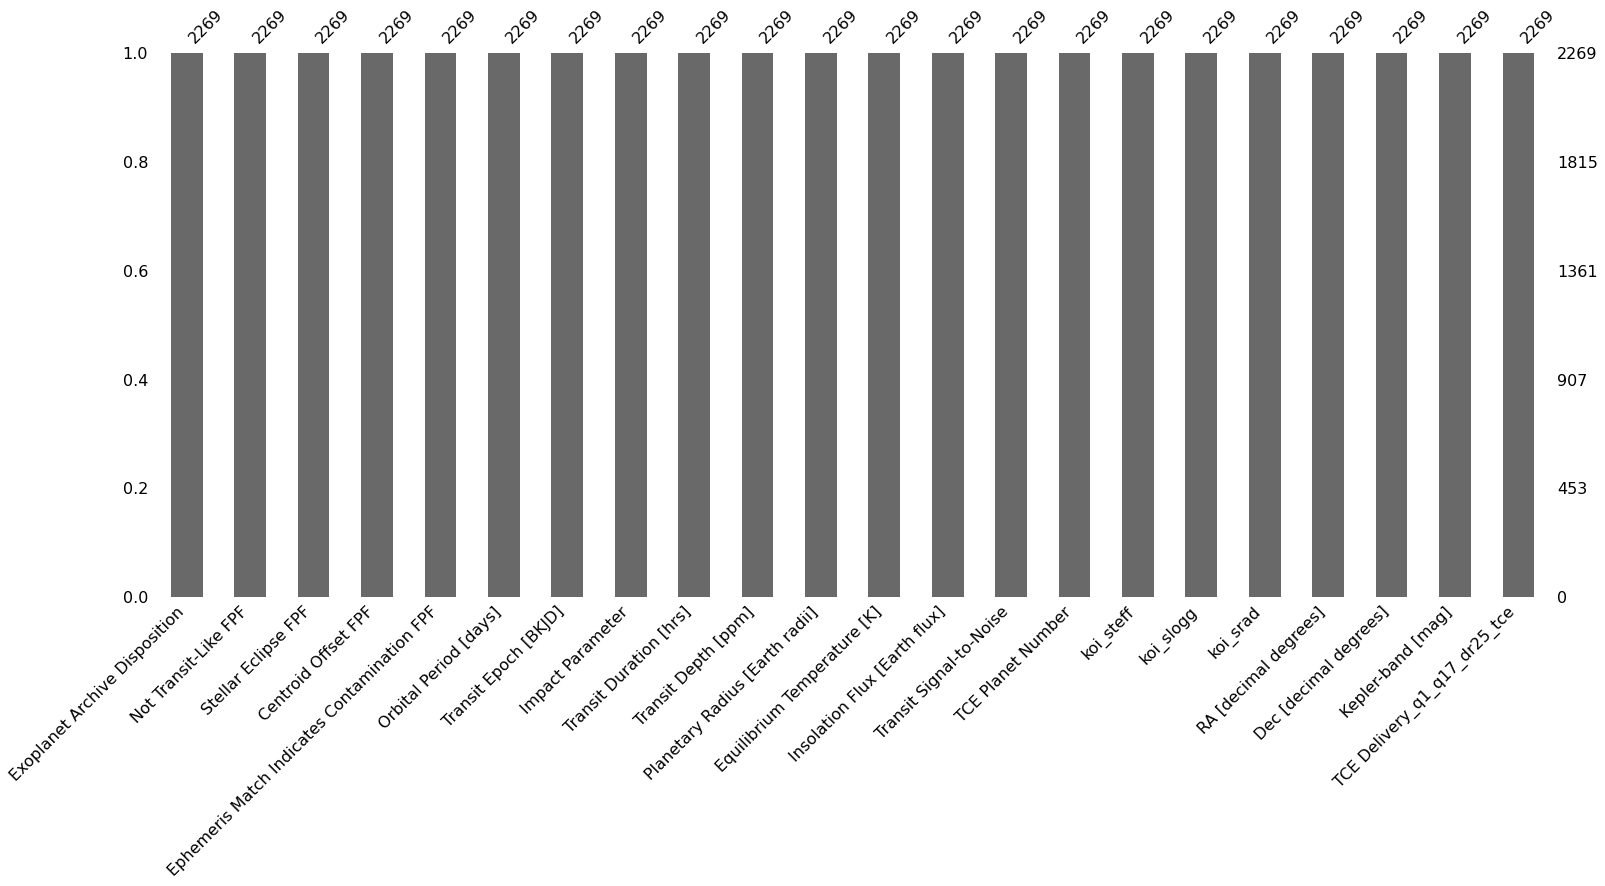

In [13]:
import missingno as ms
ms.bar(keplerProcessed_df)

In [14]:
count_nan_in_df = keplerProcessed_df.isnull().sum()
print (count_nan_in_df)

Exoplanet Archive Disposition                  0
Not Transit-Like FPF                           0
Stellar Eclipse FPF                            0
Centroid Offset FPF                            0
Ephemeris Match Indicates Contamination FPF    0
Orbital Period [days]                          0
Transit Epoch [BKJD]                           0
Impact Parameter                               0
Transit Duration [hrs]                         0
Transit Depth [ppm]                            0
Planetary Radius [Earth radii]                 0
Equilibrium Temperature [K]                    0
Insolation Flux [Earth flux]                   0
Transit Signal-to-Noise                        0
TCE Planet Number                              0
koi_steff                                      0
koi_slogg                                      0
koi_srad                                       0
RA [decimal degrees]                           0
Dec [decimal degrees]                          0
Kepler-band [mag]   

In [15]:
# Drop rows with NaN
keplerProcessedDropNull_df = keplerProcessed_df.copy(deep=True)
keplerProcessedDropNull_df = keplerProcessedDropNull_df.dropna()
keplerProcessedDropNull_df.isnull().sum().sum()

0

In [16]:
#Analyzing column variance 
df.var()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



rowid                2.946723e+06
kepid                6.675899e+12
koi_score            2.123135e-02
koi_fpflag_nt        9.606124e-03
koi_fpflag_ss        1.133248e-02
koi_fpflag_co        2.638507e-03
koi_fpflag_ec        4.407228e-04
koi_period           2.640231e+03
koi_period_err1      1.596874e-06
koi_period_err2      1.596874e-06
koi_time0bk          1.764731e+03
koi_time0bk_err1     9.374992e-05
koi_time0bk_err2     9.374992e-05
koi_impact           1.105174e-01
koi_impact_err1      6.653127e+00
koi_impact_err2      7.346714e-02
koi_duration         7.359935e+00
koi_duration_err1    2.720041e-02
koi_duration_err2    2.720041e-02
koi_depth            7.234939e+06
koi_depth_err1       3.190620e+03
koi_depth_err2       3.190620e+03
koi_prad             1.152723e+01
koi_prad_err1        6.464253e-01
koi_prad_err2        9.155251e-01
koi_teq              1.496633e+05
koi_insol            1.510697e+06
koi_insol_err1       7.802945e+05
koi_insol_err2       6.084113e+05
koi_model_snr 

In [17]:
#Selecting only numeric columns
num_columns = df.dtypes[df.dtypes != "object"].index.tolist()
variance_df = df[num_columns]

# Check mean and standard deviation
stats_df = variance_df.describe().loc[['mean', 'std']]

# Transpose the dataframe
stats_df = stats_df.T

# Add standard deviation ratios 
stats_df["ratio"]=stats_df["std"]/stats_df["mean"]
stats_df = stats_df.sort_values("ratio", ascending=False)
stats_df

,mean,std,ratio
koi_fpflag_ec,4.407228e-04,2.099340e-02,47.634021
koi_fpflag_co,2.644337e-03,5.136640e-02,19.425060
koi_fpflag_nt,9.695901e-03,9.801084e-02,10.108481
koi_fpflag_ss,1.145879e-02,1.064541e-01,9.290171
koi_impact_err1,2.971688e-01,2.579366e+00,8.679800
koi_period_err1,2.140485e-04,1.263675e-03,5.903686
koi_insol_err1,1.888243e+02,8.833428e+02,4.678121
koi_insol,3.523251e+02,1.229104e+03,3.488551
koi_model_snr,8.837360e+01,2.855268e+02,3.230906
koi_depth_err1,2.141031e+01,5.648557e+01,2.638241


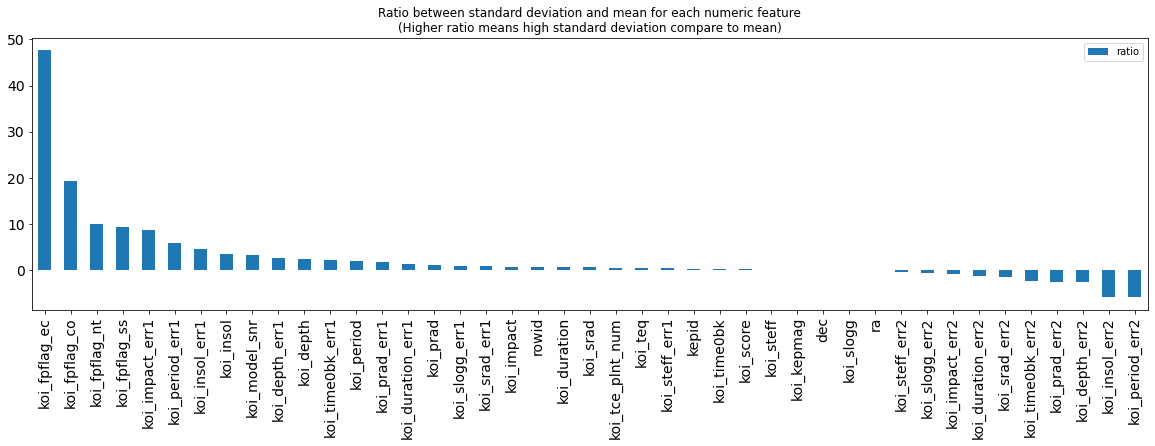

In [18]:
# Plot the standard deviation ratios columns
ax = stats_df.plot(y = "ratio", 
                   kind = "bar", 
                   figsize = (20,5), 
                   title = "Ratio between standard deviation and mean for each numeric feature\n(Higher ratio means high standard deviation compare to mean)", 
                   fontsize=14)

In [19]:
plot_Variance = px.bar(stats_df, y='ratio', title = "Ratio between standard deviation and mean for each numeric feature\n(Higher ratio means high standard deviation compare to mean)")

plot_Variance.update_layout(
    yaxis = dict(
        tickmode = 'linear',
        dtick = 2
    )
)

plot_Variance.show()

Correlation Matrix 

In [20]:
keplerCorrMatrix = keplerProcessed_df.corr()

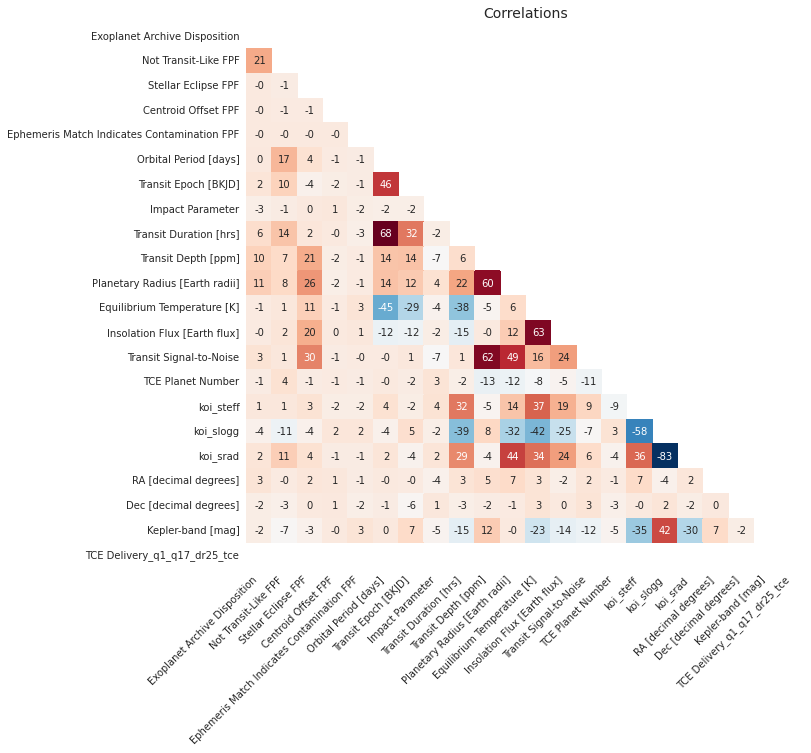

In [21]:
 # Generate a mask for the upper triangle
corr_mask = np.zeros_like(keplerCorrMatrix)
corr_mask[np.triu_indices_from(corr_mask)] = 1

# Make the figsize 9x9
plt.figure(figsize=(10,10))

# Plot heatmap of annotated correlations; change background to white
# uses seaborn
with sn.axes_style('white'):
    sn.heatmap(keplerCorrMatrix*100, 
                cmap='RdBu_r', 
                annot=True,
                fmt='.0f',
                mask=corr_mask,
                cbar=False)
    
plt.title('Correlations', fontsize=14)
plt.yticks(rotation=0)
plt.xticks(rotation=45, horizontalalignment='right')
#plt.xticks(rotation=45)
plt.show()

In [22]:
fig_corrMatrix = px.imshow(keplerCorrMatrix, width=600, height=600)
fig_corrMatrix.update_yaxes(automargin=True)
fig_corrMatrix.show()

In [23]:
# Correlation matrix on selected features
keplerCorrMatrix = keplerProcessed_df.corr()
keplerCorrMatrix

,Exoplanet Archive Disposition,Not Transit-Like FPF,Stellar Eclipse FPF,Centroid Offset FPF,Ephemeris Match Indicates Contamination FPF,Orbital Period [days],Transit Epoch [BKJD],Impact Parameter,Transit Duration [hrs],Transit Depth [ppm],...,Insolation Flux [Earth flux],Transit Signal-to-Noise,TCE Planet Number,koi_steff,koi_slogg,koi_srad,RA [decimal degrees],Dec [decimal degrees],Kepler-band [mag],TCE Delivery_q1_q17_dr25_tce
Exoplanet Archive Disposition,1.000000,0.212211,-0.002261,-0.001081,-0.000441,0.002933,0.022586,-0.025430,0.055542,0.096438,...,-0.004778,0.032478,-0.011540,0.011646,-0.036638,0.023685,0.028798,-0.019214,-0.021209,NaN
Not Transit-Like FPF,0.212211,1.000000,-0.010653,-0.005095,-0.002078,0.174139,0.098879,-0.011482,0.141599,0.068747,...,0.021355,0.010452,0.038549,0.009577,-0.112643,0.110668,-0.004017,-0.029118,-0.068295,NaN
Stellar Eclipse FPF,-0.002261,-0.010653,1.000000,-0.005544,-0.002261,0.041723,-0.038095,0.003531,0.018052,0.207711,...,0.198310,0.299256,-0.013874,0.034307,-0.037394,0.040346,0.018913,0.000820,-0.034781,NaN
Centroid Offset FPF,-0.001081,-0.005095,-0.005544,1.000000,-0.001081,-0.007052,-0.018114,0.012468,-0.000279,-0.017688,...,0.000416,-0.013283,-0.007438,-0.016572,0.017730,-0.014774,0.009268,0.007772,-0.001400,NaN
Ephemeris Match Indicates Contamination FPF,-0.000441,-0.002078,-0.002261,-0.001081,1.000000,-0.010529,-0.012507,-0.018354,-0.025090,-0.005113,...,0.009022,-0.004492,-0.011540,-0.021280,0.019357,-0.011850,-0.011130,-0.023529,0.026743,NaN
Orbital Period [days],0.002933,0.174139,0.041723,-0.007052,-0.010529,1.000000,0.463998,-0.023170,0.678125,0.139760,...,-0.123589,-0.004289,-0.002278,0.038940,-0.037692,0.020479,-0.001671,-0.012766,0.003061,NaN
Transit Epoch [BKJD],0.022586,0.098879,-0.038095,-0.018114,-0.012507,0.463998,1.000000,-0.023155,0.320187,0.144475,...,-0.115086,0.012797,-0.015056,-0.020544,0.051825,-0.042362,-0.004933,-0.057099,0.068985,NaN
Impact Parameter,-0.025430,-0.011482,0.003531,0.012468,-0.018354,-0.023170,-0.023155,1.000000,-0.018137,-0.069899,...,-0.017553,-0.070485,0.027319,0.036935,-0.023746,0.020432,-0.035901,0.011784,-0.046969,NaN
Transit Duration [hrs],0.055542,0.141599,0.018052,-0.000279,-0.025090,0.678125,0.320187,-0.018137,1.000000,0.059517,...,-0.147019,0.014762,-0.024727,0.322414,-0.393751,0.289646,0.026316,-0.026394,-0.147256,NaN
Transit Depth [ppm],0.096438,0.068747,0.207711,-0.017688,-0.005113,0.139760,0.144475,-0.069899,0.059517,1.000000,...,-0.002080,0.621886,-0.128884,-0.053812,0.080808,-0.043066,0.050555,-0.015360,0.115031,NaN


Feature histogram grid 

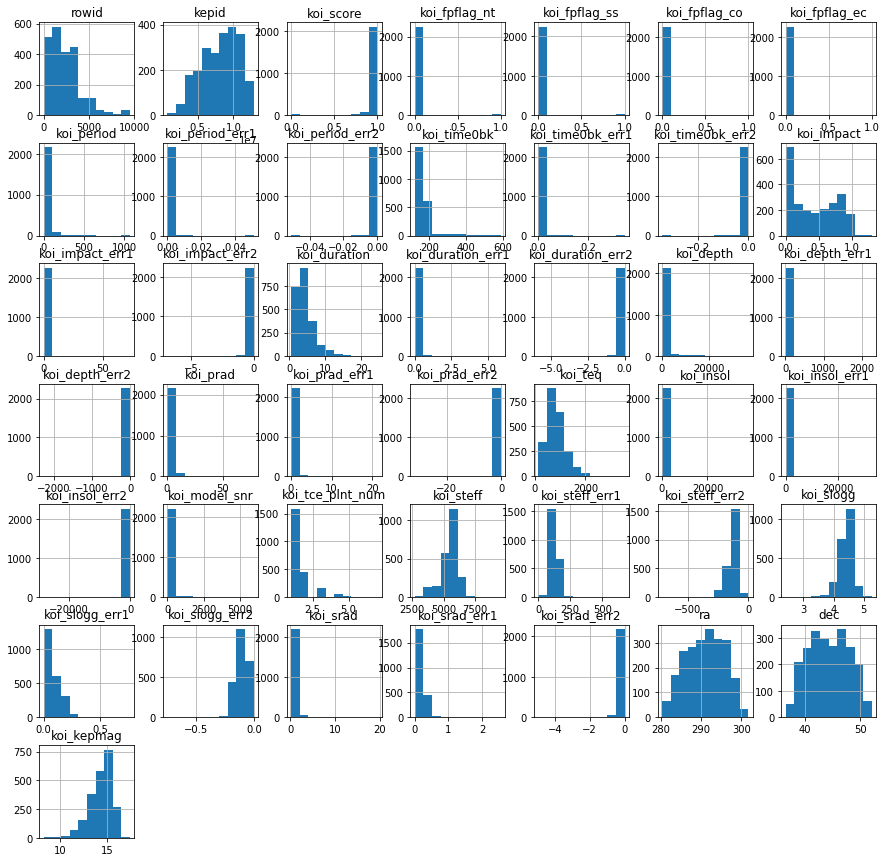

In [24]:
# Plot histogram grid
df.hist(figsize=(15,15))

plt.show()

Separate the Features (X) from the Target (y)

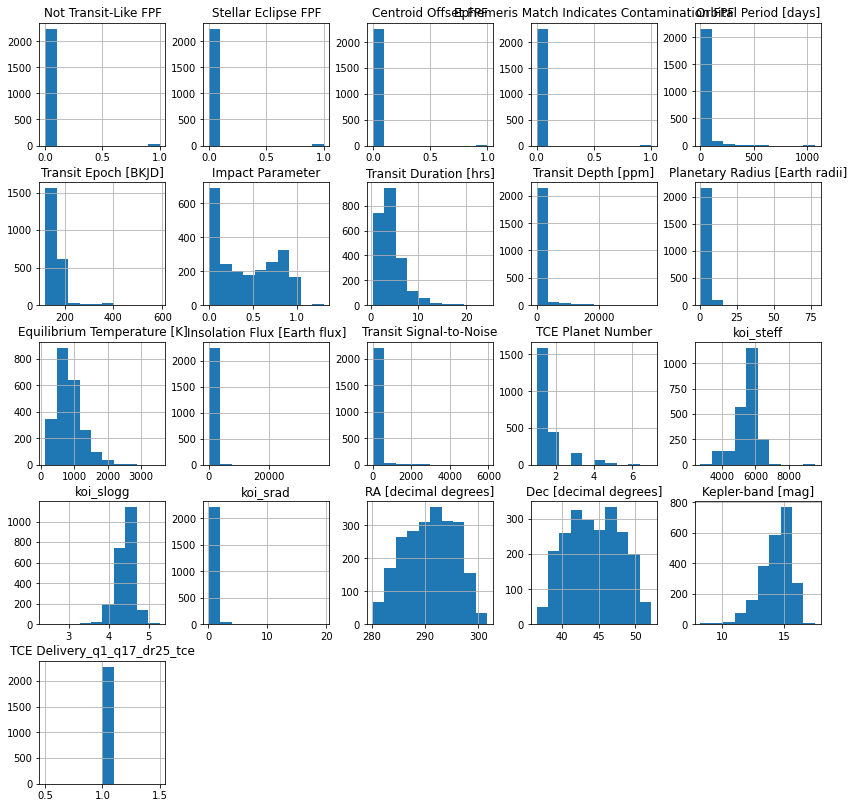

In [25]:
y = keplerProcessed_df["Exoplanet Archive Disposition"]
X = keplerProcessed_df.drop(["Exoplanet Archive Disposition"], axis =1)

# Plot histogram grid
X.hist(figsize=(14,14))

plt.show()

Split our data into training and testing

In [26]:
from sklearn.utils import shuffle
X_shuf, y_shuf = shuffle(X, y)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_shuf, 
                                                    y_shuf, 
                                                    random_state=1, 
                                                    test_size = 1/3)
X_train.shape

(1512, 21)

Scale data 

In [28]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

Supervised ML Logistic Regression Model

In [29]:
# Create the model
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

In [30]:
# Train model
classifier.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=200, random_state=1)

In [31]:
# List the features sorted in descending order by feature importance
x = sorted(zip(abs(classifier.coef_[0]), X.columns), reverse=True)
featureImp = pd.DataFrame(np.array(x).reshape(len(x),2), columns = list(["Importance","Feature"]))
featureImp

,Importance,Feature
0,0.7164544260194328,Not Transit-Like FPF
1,0.5178950869145174,Transit Depth [ppm]
2,0.3944292906691154,Planetary Radius [Earth radii]
3,0.34594807515620896,Transit Duration [hrs]
4,0.31013475242513394,Orbital Period [days]
5,0.2476315716515657,Impact Parameter
6,0.21105951253658944,koi_srad
7,0.18694295468591327,RA [decimal degrees]
8,0.17360203500203997,Dec [decimal degrees]
9,0.1600629821569707,koi_slogg


In [32]:
# Plot feature importance
plot_feature_Importance = px.bar(featureImp,
                                 x="Feature", 
                                 y="Importance",
                                 labels={
                                    "Feature": "Feature",
                                    "Importance": "Importance"
                                 }
                                )
plot_feature_Importance.update_layout(
    title={
        'text': "Feature Importance",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

plot_feature_Importance.show()

In [33]:
# Make predictions
y_pred = classifier.predict(X_test_scaled)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
752,0,0
753,0,0
754,0,0
755,0,0


In [34]:
# from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

1.0


In [50]:
import numpy as np
import statsmodels.api as sm

In [52]:
 model = sm.Logit(y, X)

In [53]:
result = model.fit(method='newton')

         Current function value: 0.000000
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [54]:
result.params

Not Transit-Like FPF                           23.008214
Stellar Eclipse FPF                           -25.396663
Centroid Offset FPF                            21.262241
Ephemeris Match Indicates Contamination FPF    23.071374
Orbital Period [days]                          -0.531565
Transit Epoch [BKJD]                            0.071710
Impact Parameter                               -5.077416
Transit Duration [hrs]                          3.141266
Transit Depth [ppm]                             0.000249
Planetary Radius [Earth radii]                  1.319482
Equilibrium Temperature [K]                    -0.040057
Insolation Flux [Earth flux]                    0.003540
Transit Signal-to-Noise                         0.005366
TCE Planet Number                              -4.700147
koi_steff                                      -0.004497
koi_slogg                                     -15.251192
koi_srad                                      -10.298051
RA [decimal degrees]           

In [56]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Logit Regression Results                                
=========================================================================================
Dep. Variable:     Exoplanet Archive Disposition   No. Observations:                 2269
Model:                                     Logit   Df Residuals:                     2248
Method:                                      MLE   Df Model:                           20
Date:                           Thu, 17 Nov 2022   Pseudo R-squ.:                   1.000
Time:                                   05:49:09   Log-Likelihood:            -4.4653e-08
converged:                                 False   LL-Null:                       -8.7269
Covariance Type:                       nonrobust   LLR p-value:                    0.6233
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Not Transit-Like FPF                           23.0082   3.55e+05   6.48e-05      1.000   -6.96e+05    6.96e+05
Stellar Eclipse FPF                           -25.3967   3.92e+06  -6.48e-06      1.000   -7.68e+06    7.68e+06
Centroid Offset FPF                            21.2622   1.03e+06   2.06e-05      1.000   -2.02e+06    2.02e+06
Ephemeris Match Indicates Contamination FPF    23.0714   2.32e+13   9.94e-13      1.000   -4.55e+13    4.55e+13
Orbital Period [days]                          -0.5316   4.77e+04  -1.12e-05      1.000   -9.34e+04    9.34e+04
Transit Epoch [BKJD]                            0.0717   3220.003   2.23e-05      1.000   -6311.018    6311.162
Impact Parameter                               -5.0774   6.64e+05  -7.65e-06      1.000    -1.3e+06     1.3e+06
Transit Duration [hrs]                          3.1413   7.55e+04   4.16e-05      1.000   -1.48e+05    1.48e+05
Transit Depth [ppm]                             0.0002     27.255   9.13e-06      1.000     -53.419      53.420
Planetary Radius [Earth radii]                  1.3195   1.86e+04   7.11e-05      1.000   -3.64e+04    3.64e+04
Equilibrium Temperature [K]                    -0.0401   4218.244   -9.5e-06      1.000   -8267.646    8267.565
Insolation Flux [Earth flux]                    0.0035    112.145   3.16e-05      1.000    -219.797     219.804
Transit Signal-to-Noise                         0.0054    580.643   9.24e-06      1.000   -1138.034    1138.045
TCE Planet Number                              -4.7001   7.79e+05  -6.03e-06      1.000   -1.53e+06    1.53e+06
koi_steff                                      -0.0045    275.392  -1.63e-05      1.000    -539.763     539.754
koi_slogg                                     -15.2512   2.11e+06  -7.24e-06      1.000   -4.13e+06    4.13e+06
koi_srad                                      -10.2981   2.79e+05  -3.69e-05      1.000   -5.47e+05    5.47e+05
RA [decimal degrees]                            0.3741   6.05e+04   6.18e-06      1.000   -1.19e+05    1.19e+05
Dec [decimal degrees]                           0.4093   2.97e+04   1.38e-05      1.000   -5.81e+04    5.81e+04
Kepler-band [mag]                              -3.6576    1.7e+05  -2.16e-05      1.000   -3.32e+05    3.32e+05
TCE Delivery_q1_q17_dr25_tce                   -8.2656   2.02e+07   -4.1e-07      1.000   -3.95e+07    3.95e+07
===============================================================================================================

Complete Separation: The results show that there iscomplete separation.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

Balanced Random Forest Classifier 

In [35]:
# Resample and fitting the training data with the BalancedRandomForestClassifier
brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=1) 
brf_model.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(random_state=1)

In [36]:
# Calculated the balanced accuracy score
y_pred = brf_model.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning:

y_pred contains classes not in y_true



0.9722589167767504

In [37]:
# List the features sorted in descending order by feature importance
sorted(zip(brf_model.feature_importances_, X.columns), reverse=True)

[(0.13793103448275862, 'Dec [decimal degrees]'),
 (0.08620689655172414, 'Transit Signal-to-Noise'),
 (0.08620689655172414, 'Impact Parameter'),
 (0.08620689655172414, 'Equilibrium Temperature [K]'),
 (0.06896551724137931, 'koi_srad'),
 (0.06896551724137931, 'Transit Duration [hrs]'),
 (0.06896551724137931, 'Orbital Period [days]'),
 (0.06896551724137931, 'Kepler-band [mag]'),
 (0.05172413793103448, 'koi_slogg'),
 (0.05172413793103448, 'Transit Epoch [BKJD]'),
 (0.05172413793103448, 'Transit Depth [ppm]'),
 (0.05172413793103448, 'Insolation Flux [Earth flux]'),
 (0.034482758620689655, 'RA [decimal degrees]'),
 (0.034482758620689655, 'Planetary Radius [Earth radii]'),
 (0.034482758620689655, 'Not Transit-Like FPF'),
 (0.017241379310344827, 'TCE Planet Number'),
 (0.0, 'koi_steff'),
 (0.0, 'TCE Delivery_q1_q17_dr25_tce'),
 (0.0, 'Stellar Eclipse FPF'),
 (0.0, 'Ephemeris Match Indicates Contamination FPF'),
 (0.0, 'Centroid Offset FPF')]

In [60]:
def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(y_test, y_pred, color='red')
    plt.plot(range(my_range), range(my_range), 'o')
    plt.title(regressorName)
    plt.show()
    return

In [62]:
y_test = range(10)
y_pred = np.random.randint(0, 10, 10)

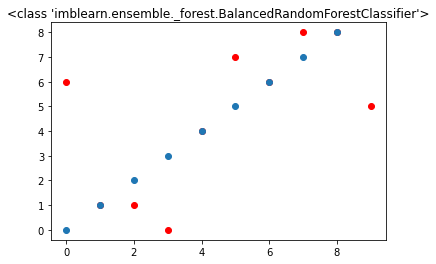

In [63]:
plotGraph(y_test,y_pred,BalancedRandomForestClassifier)

Habitable Zone Analysis 

In [38]:
df = pd.read_csv("cumulative.csv")
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
5,6,10872983,K00756.01,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
6,7,10872983,K00756.02,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


In [39]:
# Rename columns to improve legibility
df.rename(columns={'kepid' : 'KepID',
                                   'kepoi_name' : 'koi_name',
                                   'kepler_name' : 'kepler_name',
                                   'koi_disposition' : 'exoplanet_archive_disposition',
                                   'koi_pdisposition' : 'disposition_using_kepler_data',
                                   'koi_score' : 'disposition_score',
                                   'koi_fpflag_nt' : 'not_transit-like_fpf',
                                   'koi_fpflag_ss' : 'stellar_eclipse_fpf',
                                   'koi_fpflag_co' : 'centroid_offset_fpf',
                                   'koi_fpflag_ec' : 'ephemeris_match_indicates',
                                   'koi_period' : 'orbital_period[days]',
                                   'koi_time0bk' : 'transit_epoch',
                                   'koi_impact' : 'impact_parameter',
                                   'koi_duration' : 'transit_duration[hrs]',
                                   'koi_depth' : 'transit_depth[ppm]',
                                   'koi_prad' : 'planetary_radius[earth_radii]',
                                   'koi_teq' : 'equilibrium_temperature[k]',
                                   'koi_insol' : 'insolation_flux[earth_flux]',
                                   'koi_model_snr' : 'transit_signal-to-noise',
                                   'koi_tce_plnt_num' : 'tce_planet_number',
                                   'koi_tce_delivname' : 'tce_delivery',
                                   'koi_steff' : 'stellar_effective_temperature',
                                   'koi_slogg' : 'stellar_surface_gravity',
                                   'koi_smet' : 'stellar_metallicity',
                                   'koi_srad' : 'stellar_radius[solar_radii]',
                                   'koi_smass' : 'stellar_mass[solar_mass]',
                                   'ra' : 'RA[decimal_degrees]',
                                   'dec' : 'Dec[decimal_degrees]',
                                   'koi_kepmag' : 'kepler-band_[mag]'}, inplace = True)
df

,rowid,KepID,koi_name,kepler_name,exoplanet_archive_disposition,disposition_using_kepler_data,disposition_score,not_transit-like_fpf,stellar_eclipse_fpf,centroid_offset_fpf,...,koi_steff_err2,stellar_surface_gravity,koi_slogg_err1,koi_slogg_err2,stellar_radius[solar_radii],koi_srad_err1,koi_srad_err2,RA[decimal_degrees],Dec[decimal_degrees],kepler-band_[mag]
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
5,6,10872983,K00756.01,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
6,7,10872983,K00756.02,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9309,9310,7347246,K03014.01,Kepler-1411 b,CONFIRMED,CANDIDATE,0.941,0,0,0,...,-236.0,4.454,0.054,-0.216,1.053,0.357,-0.119,286.36157,42.963921,15.831
9353,9354,8895758,K03106.01,Kepler-1427 b,CONFIRMED,CANDIDATE,0.877,0,0,0,...,-203.0,4.473,0.054,-0.216,1.000,0.322,-0.107,295.34967,45.114552,15.415
9355,9356,6196457,K00285.03,Kepler-92 d,CONFIRMED,FALSE POSITIVE,0.476,1,0,0,...,-80.0,4.050,0.033,-0.027,1.670,0.118,-0.082,289.08606,41.562958,11.565
9479,9480,7503885,K03417.01,Kepler-1494 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-205.0,4.437,0.072,-0.203,1.008,0.319,-0.137,282.65741,43.162521,15.214


In [40]:
# Store relationships between the id, name, and dispositions it case its needed for future use
df = df[["KepID",
                                           "kepler_name",
                                           "exoplanet_archive_disposition",
                                           "disposition_using_kepler_data",
                                           "orbital_period[days]",
                                           "stellar_effective_temperature",
                                           "stellar_surface_gravity",
                                           "stellar_radius[solar_radii]",
                                           
                                           ]]
df

,KepID,kepler_name,exoplanet_archive_disposition,disposition_using_kepler_data,orbital_period[days],stellar_effective_temperature,stellar_surface_gravity,stellar_radius[solar_radii]
0,10797460,Kepler-227 b,CONFIRMED,CANDIDATE,9.488036,5455.0,4.467,0.927
1,10797460,Kepler-227 c,CONFIRMED,CANDIDATE,54.418383,5455.0,4.467,0.927
4,10854555,Kepler-664 b,CONFIRMED,CANDIDATE,2.525592,6031.0,4.438,1.046
5,10872983,Kepler-228 d,CONFIRMED,CANDIDATE,11.094321,6046.0,4.486,0.972
6,10872983,Kepler-228 c,CONFIRMED,CANDIDATE,4.134435,6046.0,4.486,0.972
...,...,...,...,...,...,...,...,...
9309,7347246,Kepler-1411 b,CONFIRMED,CANDIDATE,86.116089,6161.0,4.454,1.053
9353,8895758,Kepler-1427 b,CONFIRMED,CANDIDATE,0.968981,5866.0,4.473,1.000
9355,6196457,Kepler-92 d,CONFIRMED,FALSE POSITIVE,49.356791,5862.0,4.050,1.670
9479,7503885,Kepler-1494 b,CONFIRMED,CANDIDATE,91.078624,5915.0,4.437,1.008


In [41]:
# Select exoplanet candidate （ ）
Confirmed_Exoplanets_df = df.loc[(df['exoplanet_archive_disposition'] == 'CONFIRMED')
                                                   & (df['disposition_using_kepler_data'] == 'CANDIDATE')]
Confirmed_Exoplanets_df

,KepID,kepler_name,exoplanet_archive_disposition,disposition_using_kepler_data,orbital_period[days],stellar_effective_temperature,stellar_surface_gravity,stellar_radius[solar_radii]
0,10797460,Kepler-227 b,CONFIRMED,CANDIDATE,9.488036,5455.0,4.467,0.927
1,10797460,Kepler-227 c,CONFIRMED,CANDIDATE,54.418383,5455.0,4.467,0.927
4,10854555,Kepler-664 b,CONFIRMED,CANDIDATE,2.525592,6031.0,4.438,1.046
5,10872983,Kepler-228 d,CONFIRMED,CANDIDATE,11.094321,6046.0,4.486,0.972
6,10872983,Kepler-228 c,CONFIRMED,CANDIDATE,4.134435,6046.0,4.486,0.972
...,...,...,...,...,...,...,...,...
9305,8801316,Kepler-1394 b,CONFIRMED,CANDIDATE,3.937668,6277.0,3.728,2.741
9309,7347246,Kepler-1411 b,CONFIRMED,CANDIDATE,86.116089,6161.0,4.454,1.053
9353,8895758,Kepler-1427 b,CONFIRMED,CANDIDATE,0.968981,5866.0,4.473,1.000
9479,7503885,Kepler-1494 b,CONFIRMED,CANDIDATE,91.078624,5915.0,4.437,1.008


In [42]:
# Orbital period
period_exoplanets_df = Confirmed_Exoplanets_df.loc[(Confirmed_Exoplanets_df['orbital_period[days]']>200) 
                                                   & (Confirmed_Exoplanets_df['orbital_period[days]']<400)]
period_exoplanets_df
period_exoplanets_df.count()

KepID                            30
kepler_name                      30
exoplanet_archive_disposition    30
disposition_using_kepler_data    30
orbital_period[days]             30
stellar_effective_temperature    30
stellar_surface_gravity          30
stellar_radius[solar_radii]      30
dtype: int64

In [43]:
# Habitable temperature on these exoplanets

temp_exoplanets_df = Confirmed_Exoplanets_df.loc[(Confirmed_Exoplanets_df['stellar_effective_temperature']>5500) 
                                                 & (Confirmed_Exoplanets_df['stellar_effective_temperature']<6500)]
temp_exoplanets_df

,KepID,kepler_name,exoplanet_archive_disposition,disposition_using_kepler_data,orbital_period[days],stellar_effective_temperature,stellar_surface_gravity,stellar_radius[solar_radii]
4,10854555,Kepler-664 b,CONFIRMED,CANDIDATE,2.525592,6031.0,4.438,1.046
5,10872983,Kepler-228 d,CONFIRMED,CANDIDATE,11.094321,6046.0,4.486,0.972
6,10872983,Kepler-228 c,CONFIRMED,CANDIDATE,4.134435,6046.0,4.486,0.972
7,10872983,Kepler-228 b,CONFIRMED,CANDIDATE,2.566589,6046.0,4.486,0.972
10,11446443,Kepler-1 b,CONFIRMED,CANDIDATE,2.470613,5820.0,4.457,0.964
...,...,...,...,...,...,...,...,...
9219,5511081,Kepler-338 d,CONFIRMED,CANDIDATE,44.430406,5951.0,4.017,1.693
9305,8801316,Kepler-1394 b,CONFIRMED,CANDIDATE,3.937668,6277.0,3.728,2.741
9309,7347246,Kepler-1411 b,CONFIRMED,CANDIDATE,86.116089,6161.0,4.454,1.053
9353,8895758,Kepler-1427 b,CONFIRMED,CANDIDATE,0.968981,5866.0,4.473,1.000


In [44]:
# Super-Earth size plante
super_earth_df = Confirmed_Exoplanets_df.loc[(Confirmed_Exoplanets_df['stellar_radius[solar_radii]']<= 2.0)]
super_earth_df

,KepID,kepler_name,exoplanet_archive_disposition,disposition_using_kepler_data,orbital_period[days],stellar_effective_temperature,stellar_surface_gravity,stellar_radius[solar_radii]
0,10797460,Kepler-227 b,CONFIRMED,CANDIDATE,9.488036,5455.0,4.467,0.927
1,10797460,Kepler-227 c,CONFIRMED,CANDIDATE,54.418383,5455.0,4.467,0.927
4,10854555,Kepler-664 b,CONFIRMED,CANDIDATE,2.525592,6031.0,4.438,1.046
5,10872983,Kepler-228 d,CONFIRMED,CANDIDATE,11.094321,6046.0,4.486,0.972
6,10872983,Kepler-228 c,CONFIRMED,CANDIDATE,4.134435,6046.0,4.486,0.972
...,...,...,...,...,...,...,...,...
9264,10122538,Kepler-1388 c,CONFIRMED,CANDIDATE,5.536094,3891.0,4.718,0.564
9309,7347246,Kepler-1411 b,CONFIRMED,CANDIDATE,86.116089,6161.0,4.454,1.053
9353,8895758,Kepler-1427 b,CONFIRMED,CANDIDATE,0.968981,5866.0,4.473,1.000
9479,7503885,Kepler-1494 b,CONFIRMED,CANDIDATE,91.078624,5915.0,4.437,1.008


In [45]:
# Gravity
gravity_df = Confirmed_Exoplanets_df.loc[(Confirmed_Exoplanets_df['stellar_surface_gravity']>= 4.0)]
gravity_df

,KepID,kepler_name,exoplanet_archive_disposition,disposition_using_kepler_data,orbital_period[days],stellar_effective_temperature,stellar_surface_gravity,stellar_radius[solar_radii]
0,10797460,Kepler-227 b,CONFIRMED,CANDIDATE,9.488036,5455.0,4.467,0.927
1,10797460,Kepler-227 c,CONFIRMED,CANDIDATE,54.418383,5455.0,4.467,0.927
4,10854555,Kepler-664 b,CONFIRMED,CANDIDATE,2.525592,6031.0,4.438,1.046
5,10872983,Kepler-228 d,CONFIRMED,CANDIDATE,11.094321,6046.0,4.486,0.972
6,10872983,Kepler-228 c,CONFIRMED,CANDIDATE,4.134435,6046.0,4.486,0.972
...,...,...,...,...,...,...,...,...
9264,10122538,Kepler-1388 c,CONFIRMED,CANDIDATE,5.536094,3891.0,4.718,0.564
9309,7347246,Kepler-1411 b,CONFIRMED,CANDIDATE,86.116089,6161.0,4.454,1.053
9353,8895758,Kepler-1427 b,CONFIRMED,CANDIDATE,0.968981,5866.0,4.473,1.000
9479,7503885,Kepler-1494 b,CONFIRMED,CANDIDATE,91.078624,5915.0,4.437,1.008


In [46]:
# Confirmed candidates that located in habitable zone
habitable_kepler_df = Confirmed_Exoplanets_df.loc[(df['exoplanet_archive_disposition'] == 'CONFIRMED')
                                                  & (df['disposition_using_kepler_data'] == 'CANDIDATE')
                                                  & (Confirmed_Exoplanets_df['orbital_period[days]']>200) 
                                                  & (Confirmed_Exoplanets_df['orbital_period[days]']<400) 
                                                  & (Confirmed_Exoplanets_df['stellar_effective_temperature']>5500) 
                                                  & (Confirmed_Exoplanets_df['stellar_effective_temperature']<6500)
                                                  & (Confirmed_Exoplanets_df['stellar_radius[solar_radii]']<= 2.0)
                                                 
                                                  & (Confirmed_Exoplanets_df['stellar_surface_gravity']>= 4.0)
]
habitable_kepler_df.sort_values(by=['kepler_name'], ascending = False)

,KepID,kepler_name,exoplanet_archive_disposition,disposition_using_kepler_data,orbital_period[days],stellar_effective_temperature,stellar_surface_gravity,stellar_radius[solar_radii]
2896,11442793,Kepler-90 g,CONFIRMED,CANDIDATE,210.601384,5970.0,4.317,1.200
5450,12735740,Kepler-86 b,CONFIRMED,CANDIDATE,282.525356,5725.0,4.506,0.913
753,11027624,Kepler-849 b,CONFIRMED,CANDIDATE,394.624951,5910.0,4.030,1.727
1275,8692861,Kepler-69 c,CONFIRMED,CANDIDATE,242.467406,5637.0,4.399,0.943
2851,10386922,Kepler-511 b,CONFIRMED,CANDIDATE,296.637582,5866.0,4.117,1.417
5942,5437945,Kepler-460 c,CONFIRMED,CANDIDATE,220.142913,6340.0,4.163,1.393
9159,8311864,Kepler-452 b,CONFIRMED,CANDIDATE,384.847556,5579.0,4.580,0.798
5033,7703955,Kepler-315 c,CONFIRMED,CANDIDATE,265.478470,5792.0,4.375,1.005
3108,10593626,Kepler-22 b,CONFIRMED,CANDIDATE,289.864067,5516.0,4.446,0.886
8416,8891684,Kepler-1634 b,CONFIRMED,CANDIDATE,374.878133,5636.0,4.218,1.354
